# 삼성전자 주가 그래프 그리기

## 데이터 가져오기

In [23]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['font.size'] = 12

samsung = fdr.DataReader('005930', start='2019-01-01')
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,0.001292
2019-01-03,38300,38550,37450,37600,12471493,-0.029677
2019-01-04,37450,37600,36850,37450,14108958,-0.003989
2019-01-07,38000,38900,37800,38750,12748997,0.034713
2019-01-08,38000,39200,37950,38100,12756554,-0.016774


## 주가 그래프 그리기

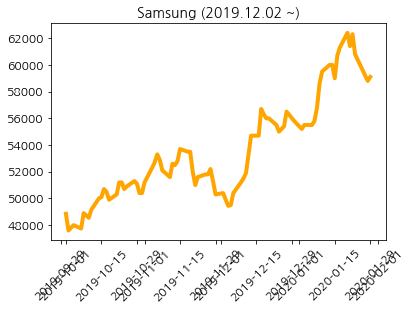

In [55]:
plt.title("Samsung (2019.12.02 ~)", fontsize=14)
plt.plot(samsung['Close'], c='orange', linewidth=4)
plt.xticks(rotation=45)
plt.show()

## 캔들스틱 그리기

### gridspec 사용법

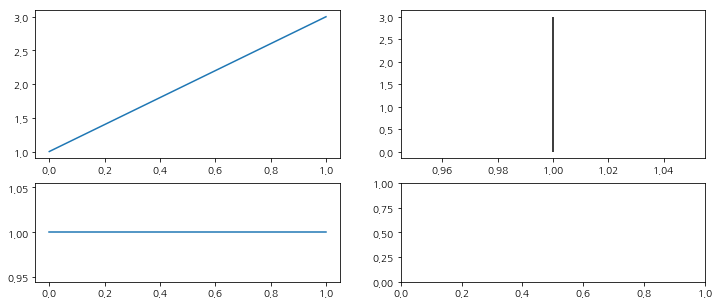

In [3]:
from matplotlib import gridspec

plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(nrows=2, # 행 개수
                       ncols=2, # 열 개수
                       height_ratios=[3, 2] # 높이 비율
                      )

plt.subplot(gs[0])
plt.plot([1, 3])

plt.subplot(gs[1])
plt.vlines(1, 0, 3)

plt.subplot(gs[2])
plt.plot([1, 1])

plt.subplot(gs[3])

plt.show()

### 삼성전자 캔들스틱 그리기

In [32]:
from datetime import date
samsung_ = samsung
samsung = samsung[date(2020,1,1):]

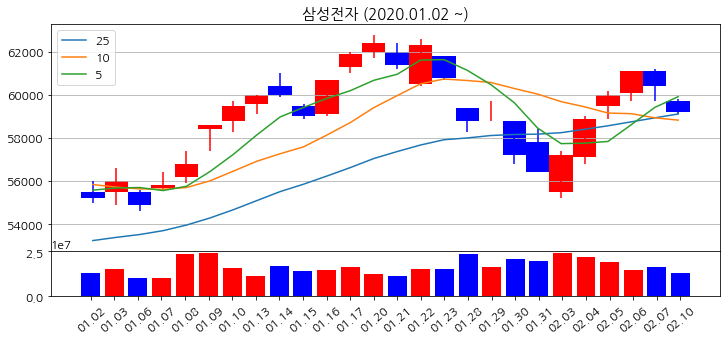

In [43]:
from matplotlib import gridspec

cmap = samsung['Change'].apply(lambda x: 'r' if x >0 else 'b')
x = list(map(lambda x: x.strftime('%m.%d'), samsung.index))

plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(nrows=2, ncols=1,
                       height_ratios=[5, 1])

plt.subplot(gs[0])
plt.title("삼성전자 (2020.01.02 ~)", fontsize=15)
plt.bar(x, height=samsung['Close']-samsung['Open'], bottom=samsung['Open'], width=1, color=cmap)

plt.vlines(x, samsung['Low'], samsung['High'], colors=cmap)
plt.xticks([])
plt.grid()
plt.legend()

plt.subplot(gs[1])
plt.bar(x, samsung['Volume'], width=0.8, color=cmap)
plt.xticks(range(0, len(x)), x, rotation=40)

plt.subplots_adjust(wspace = 0, hspace = 0)
plt.show()

# 여러 종목의 주가 그래프 동시에 그리기

## 데이터 가져오기

`TIGER 미국S&P500선물(H)`, `TIGER 차이나CSI300`, `TIGER 200`, `KODEX 골드선물(H)`, `KOSEF 미국달러선물` 데이터를 가져오겠습니다.

In [5]:
symbol_dict = {'미국':'143850', '중국':'192090',  '한국':'102110', '금':'132030','달러':'138230'}

def get_data(symbol_dict, start=None, end=None):
    data_dict = {}
    for k, v in symbol_dict.items():
        data_dict[k] = fdr.DataReader(v, start=start, end=end)
    data = pd.DataFrame({k:v['Close'] for k, v in data_dict.items()})
    return data

data = get_data(symbol_dict, '2016-01-01', '2020-01-01')
data.head()

,미국,중국,한국,금,달러
Date,,,,,
2016-01-04,23520,7758,21940,8220,11959
2016-01-05,23460,7753,22075,8305,11954
2016-01-06,23275,7860,21940,8305,12038
2016-01-07,22855,7307,21691,8455,12092
2016-01-08,22770,7501,21853,8510,12052


## 그래프 그리기

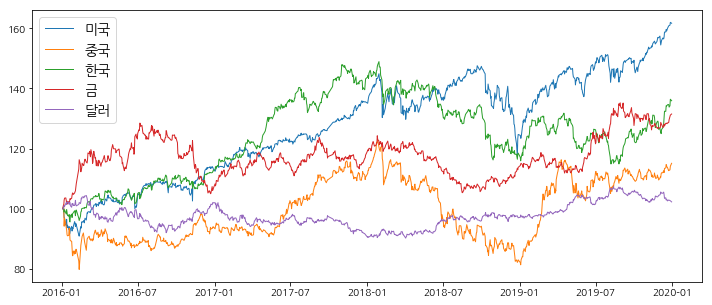

In [6]:
plt.figure(figsize=(12, 5))
for etf in data.columns:
    close = data[etf]
    plt.plot(close / close[0] * 100, linewidth=1)
plt.legend(fontsize=14)
plt.show()

# 포트폴리오 만들기

국내 상장된 ETF 리스트:
- https://finance.naver.com/sise/etf.nhn

FnGuide가 만든 시장 지수
- http://www.fnindex.co.kr/overview/I/MIS

한국거래소 지수
- http://index.krx.co.kr/main/main.jsp

In [7]:
# 코스피 200 리스트 가져오기
import requests
from bs4 import BeautifulSoup
url = "https://namu.wiki/w/KOSPI200"
res = requests.get(url)
soup = BeautifulSoup(res.text, 'html.parser')
temp = soup.select(".wiki-table tr td strong")[1:]
kospi200List = [_.text for _ in temp[1::2]]

kospiList = fdr.StockListing('KOSPI')
kospiList = kospiList.set_index('Name')
kospi200symbols = kospiList.reindex(kospi200List).dropna()
symbol_dict = {k: v for k, v in zip(kospi200symbols.index, kospi200symbols.Symbol)}

In [8]:
# 코스피 200 주가 데이터 가져오기
kospi200data = get_data(symbol_dict, start='2019-02-15')

In [9]:
# TIGER 200동일가중 ETF 데이터 가져오기
tiger200eqw = get_data({'TIGER 200동일가중':'252000'}, start='2019-02-15')

In [10]:
# 동일 가중 포트폴리오 만들기
n = len(kospi200data.columns)
w = np.ones(n) / n
ret = kospi200data.pct_change()
port = ret.dot(w)

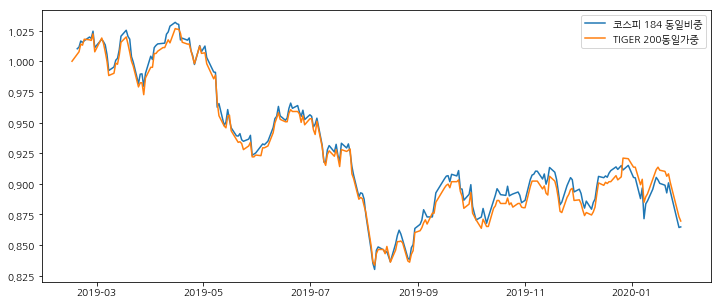

In [11]:
# 동일가중 포트폴리오와 TIGER 200동일가중 ETF 비교
plt.figure(figsize=(12, 5))
plt.plot(np.cumproduct(port+1), label='코스피 {} 동일비중'.format(n))
plt.plot(tiger200eqw / tiger200eqw.iloc[0], label='TIGER 200동일가중')
plt.legend()
plt.show()

## 동일 비중 포트폴리오

각각의 자산에 동일한 비중만큼 투자하는 포트폴리오의 그래프를 그려보겠습니다.

In [12]:
n = len(data.columns)
w_init = np.ones(n) / n
ret = data.pct_change()
port_eqweight = ret.dot(w_init)

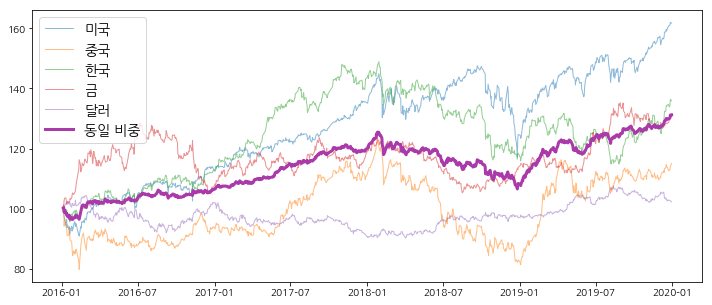

In [13]:
plt.figure(figsize=(12, 5))
for etf in data.columns:
    close = data[etf]
    plt.plot(close / close[0] * 100, linewidth=1, alpha=0.5)
plt.plot(100 * np.cumproduct(port_eqweight+1), linewidth=3, c='#aa3aaa', label='동일 비중')
plt.legend(fontsize=14)
plt.show()

# 표준편차 가중 포트폴리오

In [14]:
ret = data.pct_change()
stdinv = 1 / ret.std()
w = stdinv / stdinv.sum()
port_lowvol = ret.dot(w)

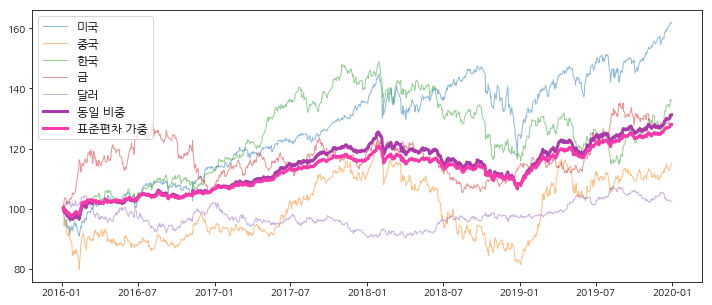

In [27]:
plt.figure(figsize=(12, 5))
for etf in data.columns:
    close = data[etf]
    plt.plot(close / close[0] * 100, linewidth=1, alpha=0.5)
plt.plot(100 * np.cumproduct(port_eqweight+1), linewidth=3, c='#aa3aaa', label='동일 비중')
plt.plot(100 * np.cumproduct(port_lowvol+1), linewidth=3, c='#fa3aaa', label='표준편차 가중')
plt.legend(fontsize=12)
plt.show()

## 최소 분산 포트폴리오

`scipy.optimize` 모듈을 이용해서 최적화를 합니다.

### 최적화 개념
y 값이 x값에 따라 변화할 때, y를 최소로 하는 x 값을 찾고자 합니다. 예를 들어 다음과 같은 식에서 y를 최소로 하는 x값을 구해보겠습니다.

- $y = x^4 -3x^3 + x$

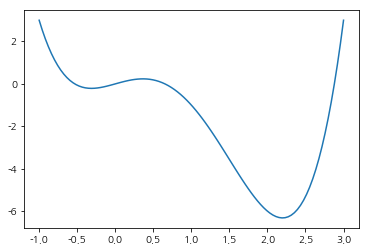

In [16]:
# x와 y의 관계를 그려봅니다
x = np.linspace(-1, 3, 100)
y = x**4 - 3*x**3 + x

plt.plot(x, y)
plt.show()

In [17]:
# 최소화하고자 하는 함수를 정의해줍니다.
def ObjFunction(x):
    y = x**4 - 3*x**3 + x
    return y

In [18]:
# 초기값 설정 후 scipy.optimize.minimize를 이용해 최적화를 합니다.
from scipy import optimize

x_init = 1
res = optimize.minimize(ObjFunction, x_init)
res

      fun: -6.3184277358067895
 hess_inv: array([[0.05431348]])
      jac: array([-2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.19826556])

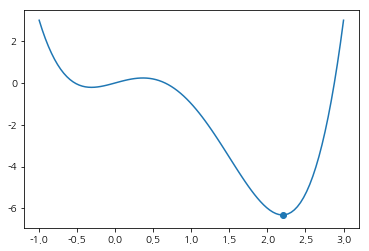

In [19]:
x = np.linspace(-1, 3, 100)
y = x**4 - 3*x**3 + x

plt.plot(x, y)
plt.scatter(res.x, ObjFunction(res.x))
plt.show()

### 분산을 최소화하는 포트폴리오 비중 구하기

In [37]:
# 목표함수를 포트폴리오의 분산으로 정의합니다. 그러면 분산을 최소화하는 비중을 구할 수 있습니다.
def ObjFunction(w, ret):
    var = ret.dot(w).var()
    return var

n = len(data.columns)
w_init = np.ones(n) / n
ret = data.pct_change()

c_ = [{'type':'eq', 'fun': lambda w: sum(w)-1. }]
b_ = [(0,1) for i in range(n)]
res = optimize.minimize(ObjFunction, w_init, ret, method='SLSQP', constraints=c_, bounds=b_, tol=1e-20)
res

     fun: 5.203005084495286e-06
     jac: array([1.04060110e-05, 1.04060115e-05, 1.04060118e-05, 1.04060113e-05,
       1.04060118e-05])
 message: 'Optimization terminated successfully.'
    nfev: 217
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([0.10946766, 0.00316792, 0.19149414, 0.19350515, 0.50236514])

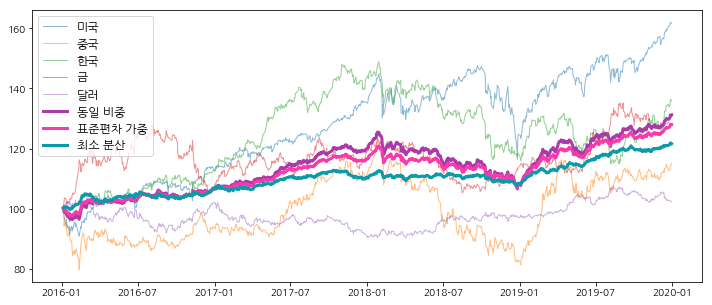

In [38]:
port_minvar = ret.dot(res.x)

plt.figure(figsize=(12, 5))
for etf in data.columns:
    close = data[etf]
    plt.plot(close / close[0] * 100, linewidth=1, alpha=0.5)

plt.plot(100 * np.cumproduct(port_eqweight+1), linewidth=3, c='#aa3aaa', label='동일 비중')
plt.plot(100 * np.cumproduct(port_lowvol+1), linewidth=3, c='#fa3aaa', label='표준편차 가중')
plt.plot(100 * np.cumproduct(port_minvar+1), linewidth=3, c='#0a9aaa', label='최소 분산')
plt.legend(fontsize=12)
plt.show()

# 효율적 경계선 구하기

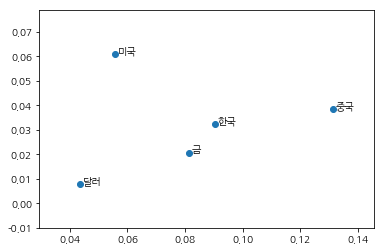

In [22]:
# 각 자산이 표준편차-평균 좌표평면 위에서 어디에 위치하는지 확인합니다.
ret = data.pct_change(120)
x, y = ret.std(), ret.mean()

plt.scatter(x, y)
for x, y, s in zip(x, y, data.columns):
    plt.text(x+0.001, y, s)
plt.show()

In [23]:
# scipy의 최적화 모듈을 함수로 만듭니다.

def ObjFunction(w, ret):
    var = ret.dot(w).var()
    return var

def get_port_weight(data, target_return, no_short=True):
    n = len(data.columns)
    w_init = np.ones(n) / n
    c_ = [{'type':'eq', 'fun': lambda w: sum(w)-1. },
          {'type':'eq', 'fun': lambda w: ret.dot(w).mean()-target_return}]
    if no_short:
        b_ = [(0,1) for i in range(n)]
    else:
        b_ = None
    res = optimize.minimize(ObjFunction, w_init, ret, method='SLSQP', constraints=c_, bounds=b_, tol=1e-20)
    return res.x

주어진 수익률 목표(`target_return`) 하에서 분산을 최소화하는 점들을 찾아 연결하면 효율적 경계선이 만들어집니다.

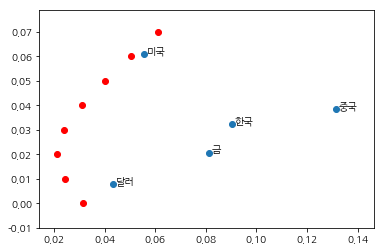

In [24]:
x, y = ret.std(), ret.mean()
plt.scatter(x, y)
for x, y, s in zip(x, y, data.columns):
    plt.text(x+0.001, y, s)
    
returns = []
for t in range(8):
    t /= 100
    w = get_port_weight(data, t, no_short=False)
    returns.append(ret.dot(w))

plt.scatter([r.std() for r in returns], [r.mean() for r in returns], c='r')
plt.show()